In [ ]:
import matplotlib.pyplot as plt
from generate_data import generate_data
from sklearn.model_selection import train_test_split
import numpy as np
from myMLlib import set_seed, rebalance_weight, plt_confusion, plt_loss,load_feather_TS,BertMHSelfAttention,multi_SA_memwise
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
import torch
from torch import optim, nn
from torch.utils.data import TensorDataset, DataLoader
from pymor.vectorarrays.numpy import NumpyVectorSpace
from training import batch_train, full_batch_train
import yaml
import os
from scipy.sparse.linalg import svds

In [ ]:
with open('hyperparameters.yml', 'r') as file:
    all_parameters = yaml.safe_load(file)
    parameters = all_parameters['real-blood-meat-time']
materials = parameters['materials']
realmater = parameters['realmater']
materials = list(materials.values())
print(materials)
print(realmater)

['Vessel', 'Tissue']
['Silicone/Water', 'Silicone']


In [ ]:
folderpath= ('/home/yuqster/files/research/dataset/realtest1',
             '/home/yuqster/files/research/dataset/realtest2',
             '/home/yuqster/files/research/dataset/realtest3',
             '/home/yuqster/files/research/dataset/realtest4',
             '/home/yuqster/files/research/dataset/realtest5',
             )
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 20,
    'axes.labelsize': 16,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 14
})
seed = 42
set_seed(seed)

In [ ]:
# Save
load_again = False
if not os.path.exists("attention_data_list.npy") or load_again:
    data_lists,labels = load_feather_TS(folderpath, materials, [200, 200, 100, 100, 100])
    attention_data = np.array(data_lists[0]+data_lists[1]+data_lists[2]+data_lists[3]).squeeze()
    attention_labels = np.array(labels[0]+labels[1]+labels[2]+labels[3]).reshape(-1,1)
    np.save("attention_data_list.npy", attention_data)
    np.save("attention_labels.npy",attention_labels)
    attention_data_r = np.array(data_lists[4]).squeeze()
    attention_labels_r = np.array(labels[4]).reshape(-1,1)
    np.save("attention_data_list_r.npy", attention_data_r)
    np.save("attention_labels_r.npy",attention_labels_r)
else:
    attention_data = np.load("attention_data_list.npy")
    attention_labels = np.load('attention_labels.npy')
    attention_data_r = np.load("attention_data_list_r.npy")
    attention_labels_r = np.load('attention_labels_r.npy')

In [91]:

# data_lists,labels = load_feather_TS(folderpath, materials, [200, 200, 100, 100, 100])
# snapshot_list = [np.array(single_data).squeeze() for single_data in data_lists[0:4]]
# snapshot_r = np.array(data_lists[4]).squeeze().reshape(-1,4096)
# label_list = [np.array(single_label).reshape(-1,1) for single_label in labels[0:4]]
# y_r = np.array(labels[4]).reshape(-1,1)

In [92]:
# if not os.path.exists('attention_Vrp.npy') or False:
#     V_list = [svds(sigsnapshot.reshape(-1,sigsnapshot.shape[-1]), k=100)[2][::-1,:].T for sigsnapshot in snapshot_list]
#     Vrp = multi_SA_memwise(V_list,r=100)
#     np.save('attention_Vrp.npy',Vrp)
# else:
#     Vrp = np.load('attention_Vrp.npy')

In [93]:
# snapshot = np.concatenate(snapshot_list,axis=0).reshape(-1,4096)
# y = np.concatenate(label_list,axis=0)
# print(snapshot.shape)
# print(y.shape)
# print(snapshot_r.shape)
# print(y_r.shape)

In [94]:
snapshot = attention_data.reshape(-1,attention_data.shape[-1])
snapshot_r = attention_data_r.reshape(-1,attention_data_r.shape[-1])
y = attention_labels
y_r = attention_labels_r
y = y.astype(np.float32)
y_r = y_r.astype(np.float32)
print(snapshot.shape)
print(snapshot_r.shape)
print(y.shape)
print(y_r.shape)


(180000, 4096)
(30000, 4096)
(36000, 1)
(6000, 1)


In [95]:
# Save
recalculate = False
if not os.path.exists("attention_V.npy") or recalculate:
    _, S, Vt = np.linalg.svd(snapshot, full_matrices=False)
    V = Vt.T
    np.save("attention_S.npy", S)
    np.save("attention_V.npy",V)
else:
    S = np.load("attention_S.npy")
    V = np.load('attention_V.npy')

In [96]:
# print(Vrp.shape)
r = 26
Vr = V[:,:r]
print(Vr.shape)

(4096, 26)


In [97]:
# energy = np.cumsum(S)/np.sum(S)*100
# plt.figure(dpi=150)
# plt.plot(energy[0:100],marker = 'o',linestyle='-',markersize = 3)
# plt.xlabel('Index')
# plt.ylabel('Energy (%)')
# plt.grid(True)
# plt.title("First 100 Modes' energy")
# plt.show
# # 假设 S 是从 np.linalg.svd 得到的奇异值数组
# plt.figure(dpi=150)
# plt.semilogy(S[:100], marker='o', linestyle='-', markersize=5)
# plt.xlabel('Index')
# plt.ylabel('Singular Value')
# plt.title("First 100 Singular Values")
# plt.grid(True)
# plt.show()

In [98]:
Xp = snapshot @ Vr
X_rp = snapshot_r @ Vr
print(Xp.shape)

(180000, 26)


In [99]:
yb = np.repeat(y,5,axis=1).reshape(-1,1)
y_rb = np.repeat(y_r,5,axis=1).reshape(-1,1)
print(f'y shape = {y.shape}, y_r shape = {y_r.shape}')
print(f'yb shape = {yb.shape}, y_rb shape = {y_rb.shape}')

y shape = (36000, 1), y_r shape = (6000, 1)
yb shape = (180000, 1), y_rb shape = (30000, 1)


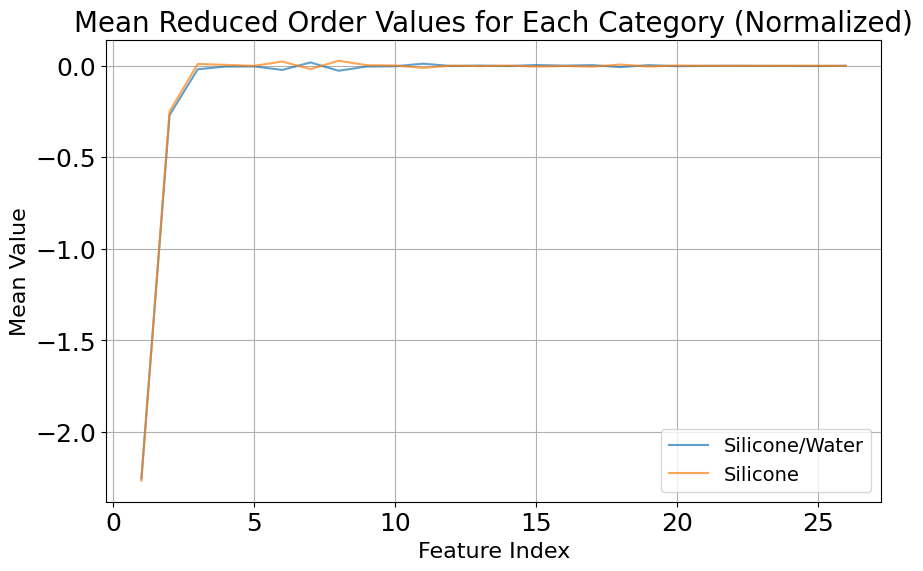

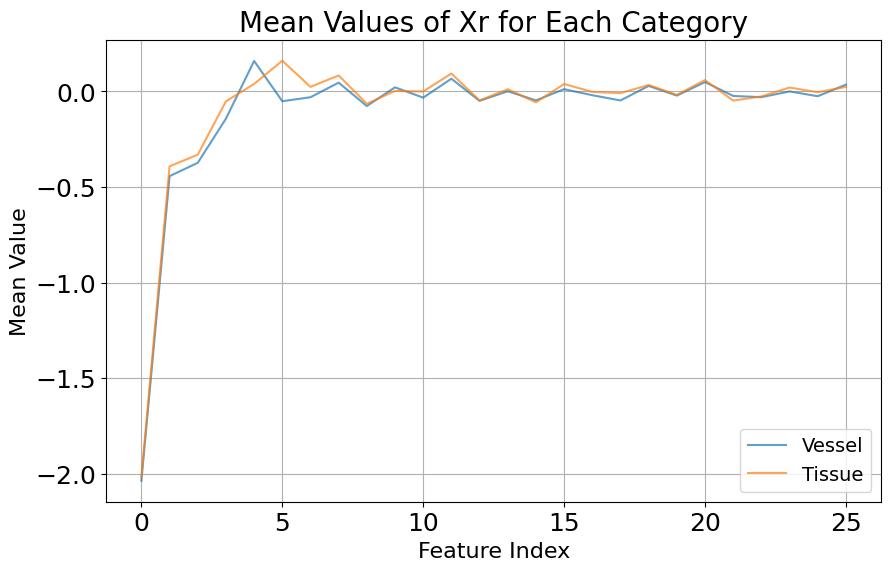

In [100]:
indices1 = {}
indices2 = {}
unique_labels = np.unique(y)
plt.figure(figsize=(10,6))
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices1[materials[i]] = np.where(yb.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = Xp[indices1[materials[i]]].mean(axis=0)
    # 绘制均值曲线
    plt.plot(range(1, mean_values.shape[0] + 1), mean_values, label=f"{realmater[int(label)]}", alpha=0.7)
plt.xlabel("Feature Index")
# plt.xlim([1,36])
plt.ylabel("Mean Value")
plt.title("Mean Reduced Order Values for Each Category (Normalized)")
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10,6))
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices2[materials[i]] = np.where(y_rb.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = X_rp[indices2[materials[i]]].mean(axis=0) # type: ignore
    # 绘制均值曲线
    plt.plot(mean_values, label=f"{materials[i]}",alpha = 0.7)
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.title("Mean Values of Xr for Each Category")
plt.legend()
plt.grid(True)
plt.show()


In [101]:
scaler = StandardScaler()

X = scaler.fit_transform(Xp)
X_r = scaler.transform(X_rp)


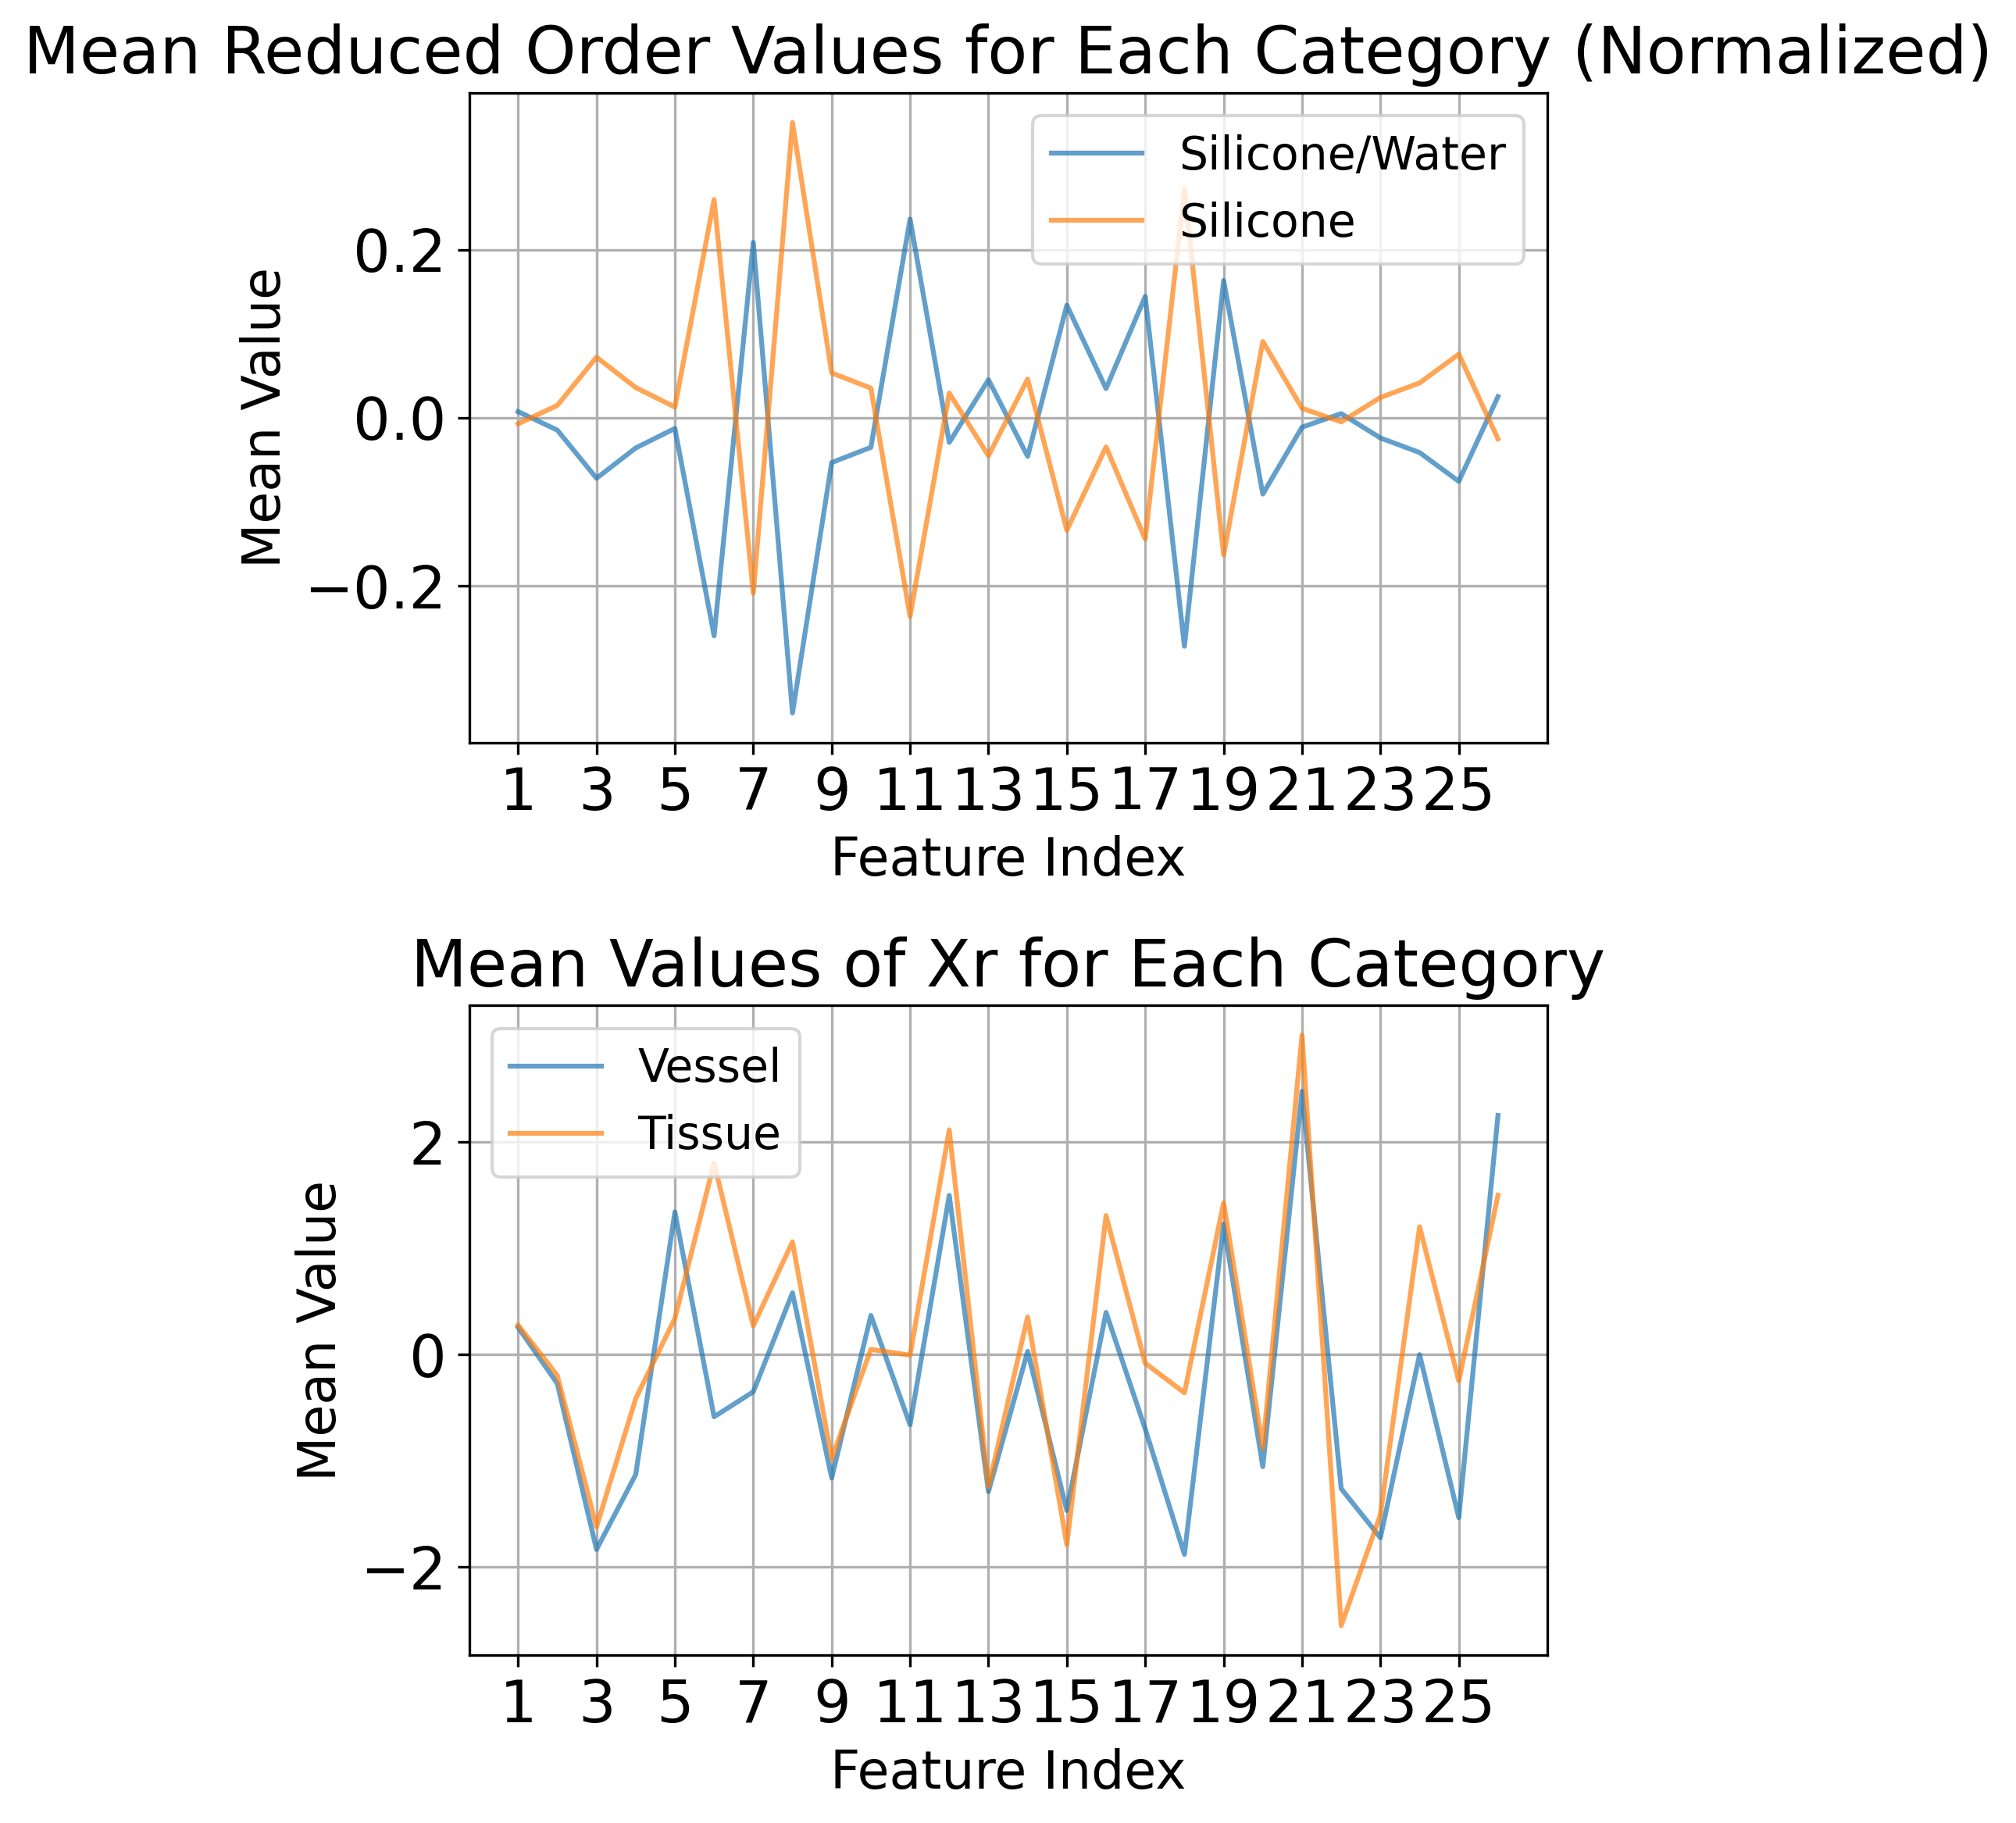

In [102]:
indices1 = {}
indices2 = {}
plt.figure(figsize=(6,8),dpi=300)
plt.subplot(211)
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices1[materials[i]] = np.where(yb.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = X[indices1[materials[i]]].mean(axis=0)
    # 绘制均值曲线
    plt.plot(range(1, mean_values.shape[0] + 1), mean_values, label=f"{realmater[int(label)]}", alpha=0.7)
plt.xlabel("Feature Index")
plt.xticks(np.arange(1, len(mean_values)+1, 2))
# plt.xlim([1,36])
plt.ylabel("Mean Value")
plt.title("Mean Reduced Order Values for Each Category (Normalized)")
plt.legend()
plt.grid(True)
plt.subplot(212)
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices2[materials[i]] = np.where(y_rb.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = X_r[indices2[materials[i]]].mean(axis=0) # type: ignore
    # 绘制均值曲线
    plt.plot(range(1, mean_values.shape[0] + 1),mean_values, label=f"{materials[i]}",alpha = 0.7)
plt.xlabel("Feature Index")
plt.xticks(np.arange(1, len(mean_values)+1, 2))
plt.ylabel("Mean Value")
plt.title("Mean Values of Xr for Each Category")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [103]:
X = X.reshape(-1,5,X.shape[-1])
X_r = X_r.reshape(-1,5,X_r.shape[-1])
print(X.shape)
print(X_r.shape)

(36000, 5, 26)
(6000, 5, 26)


In [104]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.001)
print(X_train.shape)
print(y_train.shape)
X_ver,X_te,y_ver,y_te = train_test_split(X_r, y_r, test_size=0.5)
print(X_ver.shape)
print(y_ver.shape)

(35964, 5, 26)
(35964, 1)
(3000, 5, 26)
(3000, 1)


In [105]:
device = torch.device(
    "cuda" if torch.cuda.is_available() 
    else "mps" if (hasattr(torch.backends, "mps") and torch.backends.mps.is_available()) 
    else "cpu"
)
print("Using device:", device)

Using device: cuda


In [ ]:
class TinyClassifier(nn.Module):
    def __init__(self, vec_dim=64, num_heads=2, num_classes=2, dropout = 0.01 ):
        super().__init__()
        self.cls = nn.Parameter(torch.zeros(1, 1, vec_dim))
        nn.init.trunc_normal_(self.cls,std=0.02)
        self.attn = BertMHSelfAttention(vec_dim, num_heads, attn_dropout=0, proj_dropout=0)
        self.ln = nn.LayerNorm(vec_dim)
        self.classifier = nn.Sequential(
            nn.Linear(vec_dim,12),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(12,num_classes)
            # nn.GELU(),
            # nn.Dropout(dropout),
            # nn.Linear(6,num_classes)
        )
        
        # MLP([vec_dim,24,num_classes], actfunc='GELU')

    def forward(self,x):  # token_ids: (B, T)
        B, T, C = x.shape
        cls = self.cls.expand(B,1,C)
        x = torch.cat((cls, x), dim=1)
        x = self.attn(x)                   # (B, C)  q/k/v are produced & used here
        x = self.ln(x)
        # x = x.mean(dim=1)                  # simple pooling
        logits = self.classifier(x)               # (B, num_classes)
        return logits

In [118]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).squeeze().to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).squeeze().to(device)
X_ver_tensor = torch.tensor(X_ver, dtype=torch.float32).to(device)
y_ver_tensor = torch.tensor(y_ver, dtype=torch.long).squeeze().to(device)
X_te_tensor = torch.tensor(X_te, dtype=torch.float32).to(device)
y_te_tensor = torch.tensor(y_te, dtype=torch.long).squeeze().to(device)
print(X_train_tensor.shape)
print(y_test_tensor.shape)
print(X_te_tensor.shape)
print(y_te_tensor.shape)

torch.Size([35964, 5, 26])
torch.Size([36])
torch.Size([3000, 5, 26])
torch.Size([3000])


In [119]:
set_seed(40)
model = TinyClassifier(X_train.shape[-1],num_classes=2,num_heads=2).to(device)
class_weights,_ = rebalance_weight(y_train)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

In [124]:
# model,train_losses,verify_losses = batch_train(
#                                         model=model,num_epochs=2000,
#                                         criterion=criterion,
#                                         optimizer=optimizer,
#                                         train_loader=train_loader,
#                                         verify_loader=verify_loader
#                                     )
model,train_losses,verify_losses = full_batch_train(
                                        model=model,num_epochs=10000,
                                        criterion=criterion,
                                        optimizer=optimizer,
                                        X_train_tensor=X_train_tensor,
                                        X_r_ver_tensor=X_ver_tensor,
                                        y_train_tensor=y_train_tensor,
                                        y_r_ver_tensor=y_ver_tensor
                                    )

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

In [125]:
# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_te_tensor)
    train_outputs = model(X_train_tensor)
    _, predicted = torch.max(test_outputs, 1)
    _, predicted_train = torch.max(train_outputs, 1)
    predicted_np = predicted.cpu().numpy()
    predicted_np_train = predicted_train.cpu().numpy()
    accuracy_train = accuracy_score(y_train,predicted_np_train)
    accuracy = accuracy_score(y_te, predicted_np)
    cm = confusion_matrix(y_te, predicted_np)

0.9907407407407407
0.5333333333333333


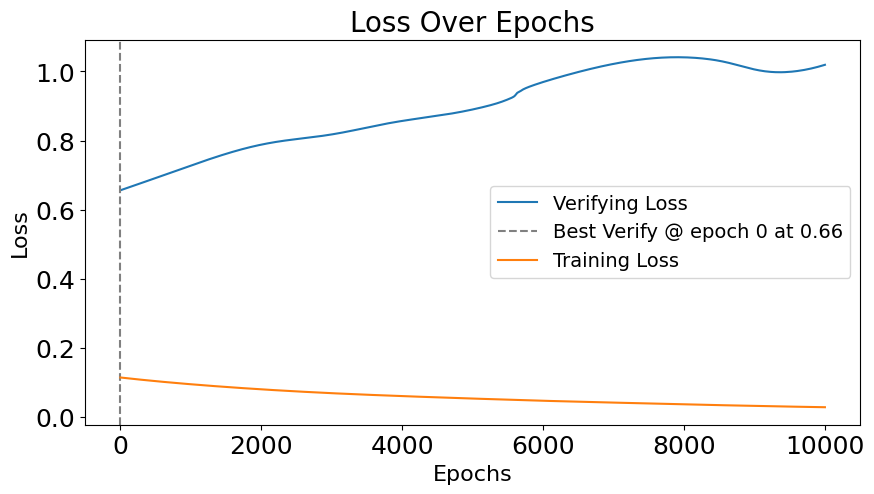

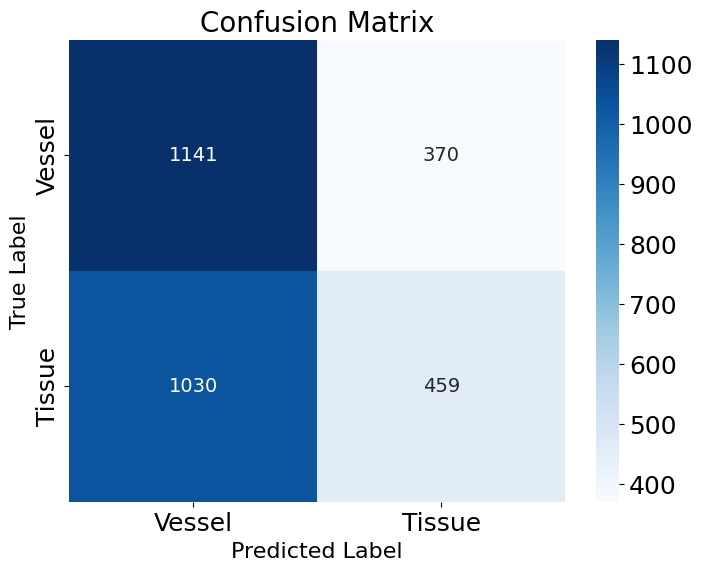

In [126]:
print(accuracy_train)
print(accuracy)
plt_loss(train_losses=train_losses,verifying_losses=verify_losses)
plt_confusion(cm, materials)

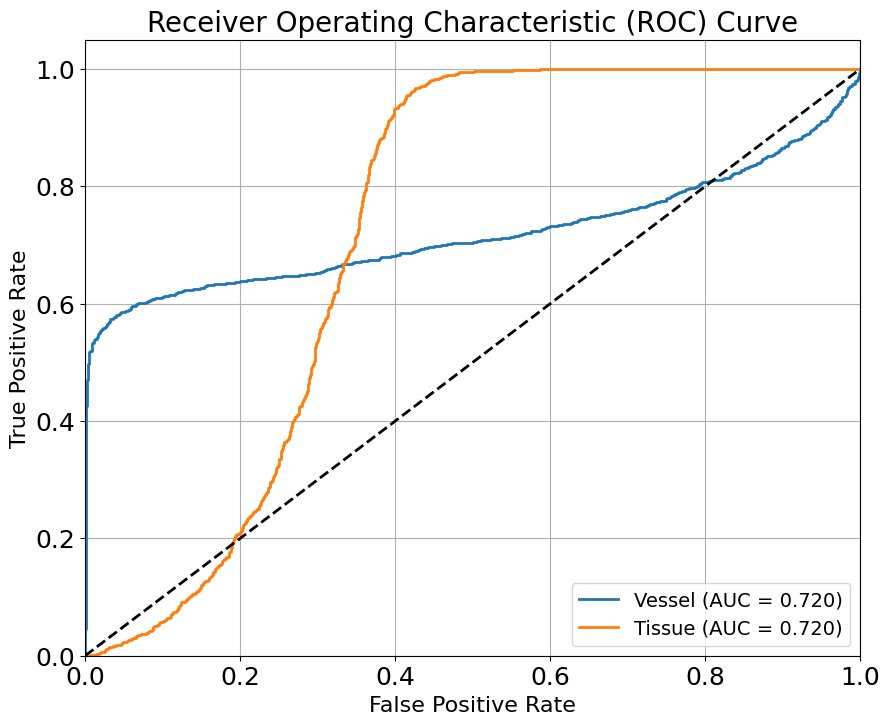

In [127]:
model.eval()
with torch.no_grad():
    logits = model(X_te_tensor.to(device))    # [N,2]
    # 方法 A：用 softmax 概率
    probs = torch.softmax(logits, dim=1)           # [N, 2]
# One-vs-rest approach for ROC curves
n_classes = len(materials)  # 3 classes: oil, water, vinegar
fpr = {}
tpr = {}
roc_auc = {}

# Get prediction probabilities for each class
probs_np = probs.cpu().numpy()

# Calculate ROC curve and ROC area for each class
for i, class_name in enumerate(materials):
	# Convert to binary classification: current class vs rest
	y_binary = (y_te.flatten() == i).astype(int)
	fpr[class_name], tpr[class_name], _ = roc_curve(y_binary, probs_np[:, i])
	roc_auc[class_name] = roc_auc_score(y_binary, probs_np[:, i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for class_name in materials:
	plt.plot(fpr[class_name], tpr[class_name], lw=2,
			 label=f'{class_name} (AUC = {roc_auc[class_name]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()